In [1]:
%load_ext autoreload
%autoreload 2

## Introduction:

The goal of this project is to recover a high resolution image from a low resolution input. In order to accomplish this goal, we will be deploying the super-resolution convolutional neural network (SRCNN) using PyTorch. This network was published in the paper, **Image Super-Resolution Using Deep Convolutional Networks** by *Chao Dong, et al. in 2014*. In addition we implemented FSRCNN **Accelerating the Super-Resolution Convolutional Neural Network**, XX and YY for ZZ purposes.

The research paper is attached in the GitHub Repository itself.

Single image super-resolution, which aims at
recovering a high-resolution image from a single low resolution image, is a classical problem in computer
vision, and the researchers named the proposed model Super-Resolution Convolutional Neural Network. (SRCNN)

The SRCNN is a deep convolutional neural network that learns end-toend mapping of resolution to high resolution images. As a result, we can use it to improve the image quality of low resolution images.

In here, we present a fully convolutional neural network for image super-resolution. The network directly learns an end-to-end mapping between low and high-resolution images, with little pre/postprocessing beyond the optimization.

To evaluate the performance of this network, we will be using two image quality metrics:

1. **Peak Signal-To-Noise Ratio(PSNR)**:- It is an expression for the ratio between the maximum possible value (power) of a signal and the power of distorting noise that affects the quality of its representation. The higher the PSNR, the better degraded image has been reconstructed to match the original image.

2. **Structural Similarity Index(SSIM)**:- The Structural SIMilarity (SSIM) index is a method for measuring the similarity between two images. The SSIM index can be viewed as a quality measure of one of the images being compared, provided the other image is regarded as of perfect quality.

Furthermore, we will be using **OpenCV** for *pre* and *post process* our images.

## 1. Importing Packages:

Here we are importing the pakages that we will be using for our project and will list out the version for each one of them.

Mainly we are using these following packages:

1. **sys** -- provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.

2. **pytorch** -- is an open-source neural-network library written in Python.

3. **cv2** -- is a library of programming functions mainly aimed at real-time computer vision.

4. **numpy** -- numerical computation library.

5. **matplotlib** -- visualization library.

6. **skimage** -- for image processing, evaluation metrics.

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import scipy, os
import h5py

# Custom Modules 
import utils, train, models

## 2. Preparing Images

For this project we will be using the same images that were used in the original SRCNN paper. All the images are under the source directory.

Now we will produce low resolution versions of these same images and we will place all the low resolution images in Images directory. 

We will accomplish the task for lowering down the resolution by resizing the images, both downwardsa and upwards, using OpenCV and will be using bilinear interpolation.

**Interpolation**:- Interpolation is the insertion of something of a different nature into something else.

**Bilinear Interpolation**:- A weighted average of the attributes (color, alpha, etc.) of the four surrounding pixels is computed and applied to the screen pixel. This process is repeated for each pixel forming the object being textured.

**Bicubic spline Interpolation**

### Testing Low Resolution Images

To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded. we will now calculate the PSNR, MSE and SSIM between our reference images and the degraded images that we just prepared.

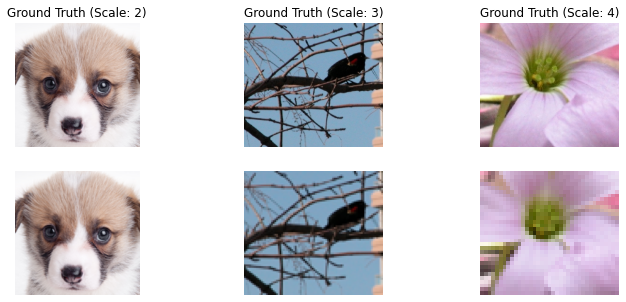

In [110]:
scales = [2,3,4]
train_folders = ['General100/', 'T91/']

fig, axs = plt.subplots(2,3, figsize=(12,5))

axInd = 0
for scale in scales:
    randomFolder = np.random.randint(0,2)
    fileList = os.listdir('SR_training_datasets/'+train_folders[randomFolder])
    randomInd = np.random.randint(0,len(fileList))
    
    hrIm = np.array(Image.open('SR_training_datasets/'+train_folders[randomFolder]+fileList[randomInd]).convert('RGB'),dtype=np.float32)
    hrIm = utils.mod_crop(hrIm,scale)
    hrIm /= 255

    # Downsample Images by Scale
    hrIm = Image.fromarray(np.uint8(hrIm*255))
    lrIm = np.array(utils.downsample_PIL(hrIm,scale,'FSRCNN'),np.float32)/255
    hrIm = np.array(hrIm,np.float32)/255

    axs[0,axInd].imshow(hrIm); axs[0,axInd].axis('off'); axs[0,axInd].set_title('Ground Truth (Scale: {})'.format(scale))
    axs[1,axInd].imshow(lrIm); axs[1,axInd].axis('off'); 
    axInd += 1


# 4. Building and Evaluating the Models

## Super Resolution Convolutional Neural Network (SRCNN)

Now that we have our low resolution images and all three image quailty metrics are working properly. Now we will start building the SRCNN model. 

In [27]:
scale = 3
utils.make_data(scale)

Creating Training Dataset..
Creating Testing Dataset..


In [19]:
num_channels = 1; filters = [128, 64]; kernels = [9, 5]
srcnn = models.SRCNN(num_channels, filters, kernels)
srcnn

SRCNN(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
  )
  (map): Sequential(
    (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (recon): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

![title](thumbnails/SRCNN.png)

Explanation for Sequences of Layers

### 5. Training the Models

Now that we have defined our models, we can use it for single-image super resolution. 

Epoch 24: 100%|██████████| 30/30 [00:01<00:00, 18.20batch/s, loss=89.6]


best epoch: 24, psnr: 30.73


Text(0, 0.5, 'Loss')

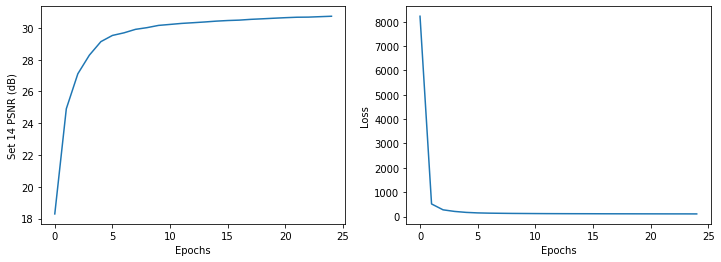

In [20]:
# training parameters
lr = 1e-3; batch_size = 64; num_epochs = 25

srcnn, metrics = train.train_model(srcnn, 'SRCNN_train.h5', 'SRCNN_test.h5', lr, batch_size, num_epochs)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(metrics['test_psnr']); ax1.set_xlabel('Epochs'); ax1.set_ylabel('PSNR (dB)'); ax1.set_title('Scale = ' + str(scale) ); ax1.legend(['Set 5'])
ax2.plot(metrics['loss']); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss')

### 6. Evaluating the Models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


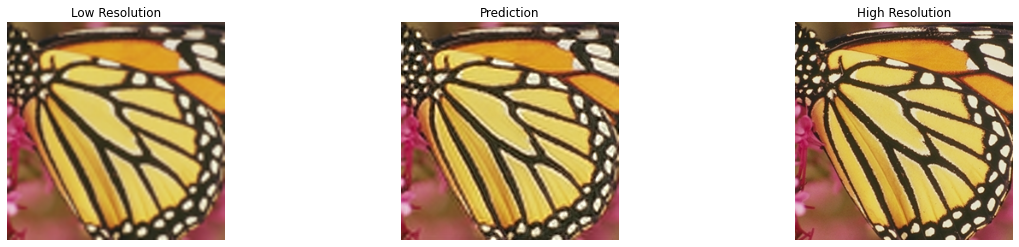

In [21]:
file = h5py.File('data/SRCNN_eval.h5','r')

hr = file['Set5/hr']['3'][:]
lr = file['Set5/lr']['3'][:]

file.close()

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.imshow(lr/255); ax1.set_title('Low Resolution'); ax1.axis('off')
pred = utils.srcnn_prediction(srcnn,lr/255)
ax2.imshow(pred); ax2.set_title('Prediction'); ax2.axis('off')
ax3.imshow(hr/255); ax3.set_title('High Resolution'); ax3.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


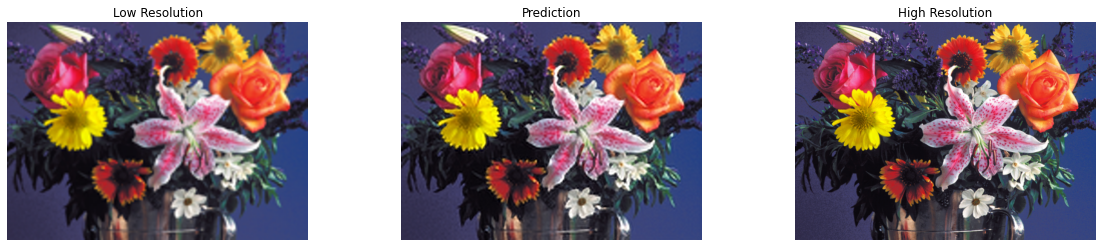

In [45]:
file = h5py.File('data/SRCNN_eval.h5','r')

hr = file['Set14/hr']['2'][:]
lr = file['Set14/lr']['2'][:]

file.close()

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.imshow(lr/255); ax1.set_title('Low Resolution'); ax1.axis('off')
pred = utils.srcnn_prediction(srcnn,lr/255)
ax2.imshow(pred); ax2.set_title('Prediction'); ax2.axis('off')
ax3.imshow(hr/255); ax3.set_title('High Resolution'); ax3.axis('off')
plt.show()

In [15]:
import torch
state_dict = srcnn.state_dict()
for n, p in torch.load('srcnn_x3.pth', map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)

#### scale = 3
|  | Set 5 | Set 14 |
| --- | :---:  | :---: |
| PSNR | 25.34 | 27.88 |
| SSIM | 23.1  | 32.42 |

## FSRCNN

In [18]:
# Prepare Training and Test Images for given scale
scale = 3

tt = utils.make_data(scale,model='FSRCNN')

Creating Training Dataset..
Creating Testing Dataset..


In [3]:
scale = 3; num_channels = 1; d = 56; s = 12; m = 4
fsrcnn = models.FSRCNN(scale, num_channels, d, s, m)
fsrcnn

FSRCNN(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
  )
  (shrink): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (map): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=12)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=12)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=12)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=12)
  )
  (expand): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=56)
  )
  (deconv): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(3, 3), padding=(4, 4), output_padding=(2, 2))
)

![title](thumbnails/FSRCNN.png)

Epoch 24: 100%|██████████| 63/63 [00:01<00:00, 33.13batch/s, loss=1.19e+7]


best epoch: 24, psnr: 25.54


Text(0, 0.5, 'Loss')

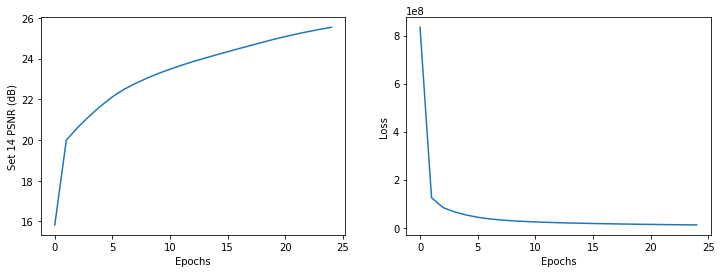

In [4]:
# training parameters
lr = 1e-3; batch_size = 32; num_epochs = 25

srcnn, metrics = train.train_model(fsrcnn, 'FSRCNN_train.h5', 'FSRCNN_test.h5', lr, batch_size, num_epochs)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.plot(metrics['test_psnr']); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Set 14 PSNR (dB)')
ax2.plot(metrics['loss']); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


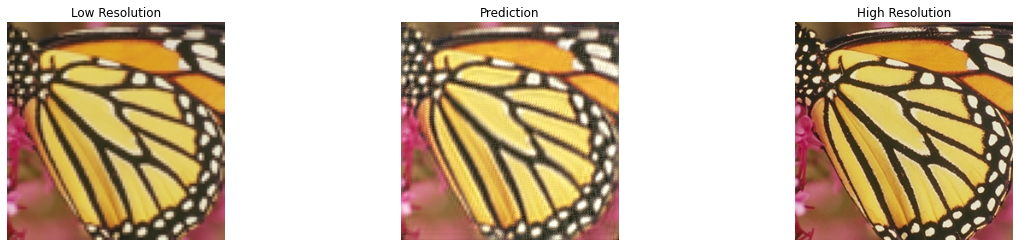

In [7]:
file = h5py.File('data/FSRCNN_eval.h5','r')

hr = file['Set5/hr']['3'][:]
lr = file['Set5/lr']['3'][:]

file.close()

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.imshow(lr/255); ax1.set_title('Low Resolution'); ax1.axis('off')
pred = utils.prediction(fsrcnn,lr/255)
ax2.imshow(pred/255); ax2.set_title('Prediction'); ax2.axis('off')
ax3.imshow(hr/255); ax3.set_title('High Resolution'); ax3.axis('off')
plt.show()